Few-View CT (ADMM w/ Total Variation)
=====================================

This example demonstrates the use of class
[admm.ADMM](../_autosummary/scico.admm.rst#scico.admm.ADMM) to solve a
few-view CT reconstruction problem with anisotropic total variation
(TV) regularization.

  $$\mathrm{argmin}_{\mathbf{x}} \; (1/2) \| \mathbf{y} - A \mathbf{x}
  \|_2^2 + \lambda \| C \mathbf{x} \|_1 \;,$$

where $A$ is the Radon transform, $\mathbf{y}$ is the sinogram, $C$ is
a 2D finite difference operator, and $\mathbf{x}$ is the desired
image.

In [1]:
import numpy as np

import jax

from mpl_toolkits.axes_grid1 import make_axes_locatable
from xdesign import Foam, discrete_phantom

import scico.numpy as snp
from scico import functional, linop, loss, metric, plot
from scico.admm import ADMM, LinearSubproblemSolver
from scico.linop.radon_astra import ParallelBeamProjector
plot.config_notebook_plotting()

Create a ground truth image.

In [2]:
N = 512  # phantom size
x_gt = discrete_phantom(Foam(size_range=[0.075, 0.0025], gap=1e-3, porosity=1), size=N)
x_gt = jax.device_put(x_gt)  # convert to jax type, push to GPU

Configure CT projection operator and generate synthetic measurements.

In [3]:
n_projection = 45  # number of projections
angles = np.linspace(0, np.pi, n_projection)  # evenly spaced projection angles
A = ParallelBeamProjector(x_gt.shape, 1, N, angles)  # Radon transform operator
y = A @ x_gt  # sinogram

Set up ADMM solver object.

In [4]:
λ = 2e-0  # L1 norm regularization parameter
ρ = 5e-0  # ADMM penalty parameter
maxiter = 25  # number of ADMM iterations
num_inner_iter = 20  # number of CG iterations per ADMM iteration

g = λ * functional.L1Norm()  # regularization functionals gi
C = linop.FiniteDifference(input_shape=x_gt.shape)  # analysis operators Ci

f = loss.SquaredL2Loss(y=y, A=A)

x0 = snp.clip(A.fbp(y), 0, 1.0)

solver = ADMM(
    f=f,
    g_list=[g],
    C_list=[C],
    rho_list=[ρ],
    x0=x0,
    maxiter=maxiter,
    subproblem_solver=LinearSubproblemSolver(cg_kwargs={"maxiter": num_inner_iter}),
    verbose=True,
)

Run the solver.

In [5]:
solver.solve()
hist = solver.itstat_object.history(transpose=True)
x_reconstruction = snp.clip(solver.x, 0, 1.0)

Iter  Time      Objective  Primal Rsdl  Dual Rsdl
-------------------------------------------------
   0  2.74e+00  9.652e+03    1.152e+02  3.143e+02


   1  4.01e+00  4.621e+03    1.209e+02  2.343e+01


   2  4.25e+00  7.318e+03    6.251e+01  2.313e+01


   3  4.50e+00  1.364e+04    4.450e+01  2.464e+01


   4  4.75e+00  1.906e+04    3.555e+01  2.214e+01


   5  5.02e+00  2.365e+04    2.900e+01  2.070e+01


   6  5.28e+00  2.674e+04    2.578e+01  1.791e+01


   7  5.55e+00  2.871e+04    2.230e+01  1.542e+01


   8  5.80e+00  2.985e+04    2.042e+01  1.400e+01


   9  6.04e+00  3.064e+04    1.854e+01  1.242e+01


  10  6.30e+00  3.102e+04    1.713e+01  1.158e+01


  11  6.53e+00  3.135e+04    1.581e+01  1.067e+01


  12  6.81e+00  3.148e+04    1.479e+01  1.014e+01


  13  7.06e+00  3.165e+04    1.379e+01  9.429e+00


  14  7.34e+00  3.169e+04    1.297e+01  9.162e+00


  15  7.58e+00  3.178e+04    1.223e+01  8.382e+00


  16  7.83e+00  3.182e+04    1.145e+01  9.379e+00


  17  8.09e+00  3.184e+04    1.072e+01  7.696e+00


  18  8.33e+00  3.185e+04    1.055e+01  7.632e+00


  19  8.57e+00  3.191e+04    9.937e+00  6.665e+00


  20  8.85e+00  3.192e+04    9.460e+00  6.732e+00


  21  9.17e+00  3.197e+04    9.054e+00  6.293e+00


  22  9.87e+00  3.197e+04    8.663e+00  6.111e+00


  23  1.01e+01  3.201e+04    8.290e+00  5.887e+00


  24  1.04e+01  3.201e+04    7.949e+00  5.634e+00


Show the recovered image.

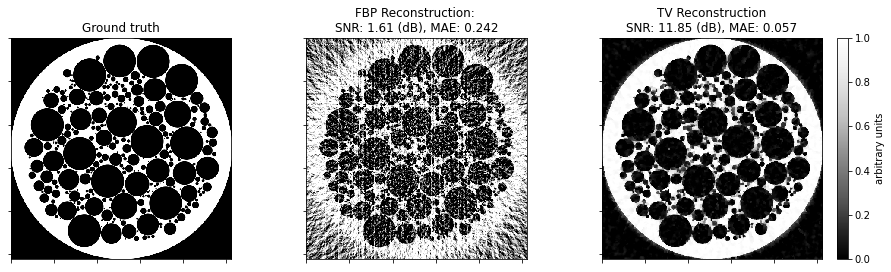

In [6]:
fig, ax = plot.subplots(nrows=1, ncols=3, figsize=(15, 5))
plot.imview(x_gt, title="Ground truth", cbar=None, fig=fig, ax=ax[0])
plot.imview(
    x0,
    title="FBP Reconstruction: \nSNR: %.2f (dB), MAE: %.3f"
    % (metric.snr(x_gt, x0), metric.mae(x_gt, x0)),
    cbar=None,
    fig=fig,
    ax=ax[1],
)
plot.imview(
    x_reconstruction,
    title="TV Reconstruction\nSNR: %.2f (dB), MAE: %.3f"
    % (metric.snr(x_gt, x_reconstruction), metric.mae(x_gt, x_reconstruction)),
    fig=fig,
    ax=ax[2],
)
divider = make_axes_locatable(ax[2])
cax = divider.append_axes("right", size="5%", pad=0.2)
fig.colorbar(ax[2].get_images()[0], cax=cax, label="arbitrary units")
fig.show()

Plot convergence statistics.

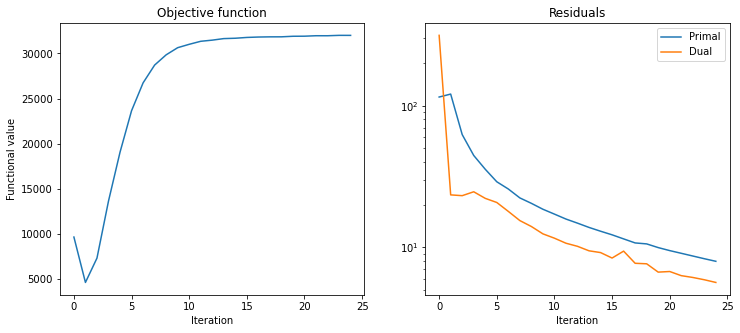

In [7]:
fig, ax = plot.subplots(nrows=1, ncols=2, figsize=(12, 5))
plot.plot(
    hist.Objective,
    title="Objective function",
    xlbl="Iteration",
    ylbl="Functional value",
    fig=fig,
    ax=ax[0],
)
plot.plot(
    snp.vstack((hist.Primal_Rsdl, hist.Dual_Rsdl)).T,
    ptyp="semilogy",
    title="Residuals",
    xlbl="Iteration",
    lgnd=("Primal", "Dual"),
    fig=fig,
    ax=ax[1],
)
fig.show()